In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
from datetime import timedelta
from dateutil.tz import tzlocal
%matplotlib inline

In [2]:
world_poppercap = 7700000000 / 1000000
us_poppercap = 329877505 / 1000000
la_poppercap = 4648794 / 1000000

ticks = 10  #number of X ticks


In [3]:
def weekofyear(date):
    """
    Convert date to week of year for plotting weekly data
    Intended use for pandas.dataframe.map
    Need to be done before dropping yeah from date
    """
    dt = datetime.strptime(date, '%Y-%m-%d')
    week = int(dt.strftime('%U'))
    
    #adjust for 2021
    if dt.year > 2020:
        week += 52
    
    return week


def rollingavg(y, days = 7):
    y = np.array(y)
    
    output = np.zeros((y.shape[0] * days), dtype=np.float64).reshape((y.shape[0],days))
        
    for idx in range(days,y.shape[0]):
        output[idx] = y[idx-days:idx]
    
    return np.nanmean(output,axis=1)
    
def newstats(df):
    """
        Changes daily totals to new cases and new deaths and adds them to dateframe
    """
    #changing daily totals to new cases
    newcases = np.zeros(df.shape[0], dtype=np.int32)
    newdeaths = np.zeros(df.shape[0], dtype=np.int32)
    deathscolumn = df.columns.get_loc('deaths')
    casescolumn = df.columns.get_loc('cases')

    newcases[0] = df.iloc[0,casescolumn]
    newdeaths[0] = df.iloc[0,deathscolumn]


    for idx in df.index[1:]:
        newcases[idx] = df.iloc[idx,casescolumn] - df.iloc[idx-1,casescolumn]
        newdeaths[idx] = df.iloc[idx,deathscolumn] - df.iloc[idx-1,deathscolumn]

    df['NewCases'] = newcases
    df['NewDeaths'] = newdeaths
    df['NewCasesRollAvg'] = rollingavg(newcases)
    df['NewDeathsRollAvg'] = rollingavg(newdeaths)

def drawindexofCDCdataloss(df,ax, color="magenta", label="CDC Loses Ctrl"):
    pass
    
def getyTicks(df, columns, yticks=8):
    """
        Gets yTicks and returns labels
    """
    dfmax = np.max(df[columns])
    items_per_tick = dfmax / yticks
    out_yticks = np.arange(0,dfmax,items_per_tick)
    #axs[0].set_yticks(la_yticks)
    out_ticklabels = []
    for i in out_yticks:
        if i > 1000000:
            out_ticklabels.append("{0:,.3g}M".format(i/1000000.))
        elif i > 10000:
            out_ticklabels.append("{0:,.3g}K".format(i/1000.0))
        else:
            out_ticklabels.append("{0:,.0f}".format(i))

    return (out_yticks, out_ticklabels)
    
#This is to mark the dataset problem mentioned above

def LACFline(df,ax):
    """
        Adds a line for data adjustment to LA data on 6/19 mentioned above.  nytimes issues 377
        This has become less relavent and so isn't being used
    """
    
    idx = df[df['date']=='06-19'].index.values[0]
    line = ax.axvline(idx,ymin=0,ymax=1,color='r',label="LA Data Adjust", zorder=-100)
    
    return line

def holidays(df,ax):
    """
        Adds lines for major holiday
        
    """
    holidays_list = [
        ('2020-03-25','Memorial Day'),
        ('2020-07-04', '4th of July'),
        ('2020-04-12','Easter'),
        ('2020-09-07','Labor Day'),
        ('2020-11-27','Thanksgiving'),
        ('2021-01-01','New Years')
    ]
    
    label = "Holiday"
    for h in holidays_list:
        #circling back to this
        #line = ax.axvline(df[df['date']==h[0]].index.values[0],ymin=0,ymax=1,color='pink',label=label, zorder=-100)
        #label = None
        pass
    
    #return line
    return None
    
def ladhdatamax(ax):
    """
        Adds a line where the LaDH data stops
    """
    return ax.axvline(orleans_df.index[-1]+1, color='red', label='End LaDH dataset', alpha=0.5)


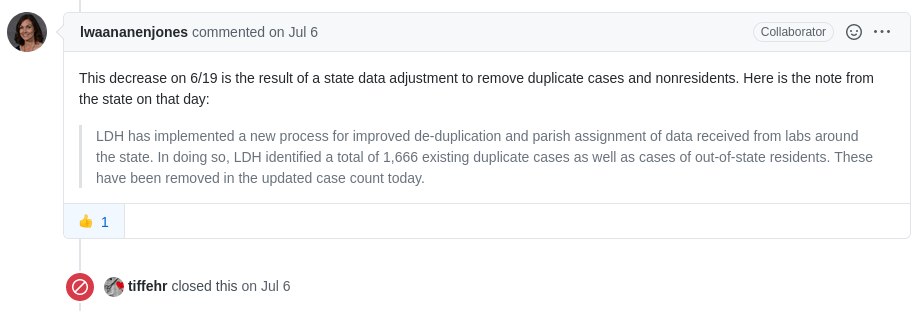

There was an issue with one of the days in louisiana which caused a negative result in the newcases for 6/19

https://github.com/nytimes/covid-19-data/issues/377

In [4]:
#state_df = pd.read_csv('./us-states.csv')
state_df = pd.read_csv('./covid-19-data/us-states.csv')  #moved nytimes data to submodule

la_df = state_df[state_df['state'] == 'Louisiana']
la_df = la_df.sort_values(['date'], ascending=True)

#week of year
la_df['week'] = la_df['date'].map(weekofyear)  #maybe this will be used again later

#little bit of a year 2000 problem here
#shorten date  
#la_df['date'] = la_df['date'].map(lambda x: x[5:])

la_df['cases_ravg'] = rollingavg(la_df['cases'])
la_df['deaths_ravg'] = rollingavg(la_df['deaths'])

la_df.index = np.arange(la_df.shape[0])
newstats(la_df)

la_df['NewCasesPerCapita'] = la_df['NewCases'] / la_poppercap
la_df['NewDeathsPerCapita'] = la_df['NewDeaths'] / la_poppercap

la_df['NewCasesPerCapita_ravg'] = rollingavg(la_df['NewCasesPerCapita'])
la_df['NewDeathsPerCapita_ravg'] = rollingavg(la_df['NewDeathsPerCapita'])

la_items_pertick = la_df.shape[0] / ticks
la_ticks = np.append(np.arange(0,la_df.shape[0], la_items_pertick), [la_df.shape[0]-1])
la_items_pertick += 1


la_df.tail(2)


,date,state,fips,cases,deaths,week,cases_ravg,deaths_ravg,NewCases,NewDeaths,NewCasesRollAvg,NewDeathsRollAvg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
383,2021-03-27,Louisiana,22,443069,10087,64,441460.142857,10037.000000,0,0,476.0,14.142857,0.0,0.0,102.392147,3.042264
384,2021-03-28,Louisiana,22,443069,10087,65,441936.142857,10051.142857,0,0,476.0,14.142857,0.0,0.0,102.392147,3.042264


In [5]:
us_df = pd.read_csv('./covid-19-data/us.csv')  
us_df = us_df.sort_values('date')
us_df[us_df['date'] == '2020-03-09']

#slice to match up with Louisiana data for better comparison
us_df = us_df.iloc[48:,:]

#week of year
us_df['week'] = us_df['date'].map(weekofyear)  #maybe this will be used again later

#little bit of a year 2000 problem ghere
#shorten date
#us_df['date'] = us_df['date'].map(lambda x: x[5:])

us_df['cases_ravg'] = rollingavg(us_df['cases'])
us_df['deaths_ravg'] = rollingavg(us_df['deaths'])

us_df.index = np.arange(us_df.shape[0])
newstats(us_df)

us_df['NewCasesPerCapita'] = us_df['NewCases'] / us_poppercap
us_df['NewDeathsPerCapita'] = us_df['NewDeaths'] / us_poppercap

us_df['NewCasesPerCapita_ravg'] = rollingavg(us_df['NewCasesPerCapita'])
us_df['NewDeathsPerCapita_ravg'] = rollingavg(us_df['NewDeathsPerCapita'])

us_items_pertick = us_df.shape[0] / ticks
us_ticks = np.append(np.arange(0,us_df.shape[0], us_items_pertick),[us_df.shape[0]-1])
us_items_pertick += 1

#used to set xlim to lign up graphs
xdatalen = us_df.index.shape[0]
us_df.tail(2)

,date,cases,deaths,week,cases_ravg,deaths_ravg,NewCases,NewDeaths,NewCasesRollAvg,NewDeathsRollAvg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
383,2021-03-27,30239893,548380,64,2.997455e+07,544072.285714,60302,780,60772.857143,982.857143,182.801189,2.364514,184.228558,2.979461
384,2021-03-28,30285445,548867,65,3.003613e+07,545056.142857,45552,487,61583.000000,983.857143,138.087621,1.476306,186.684448,2.982492


In [6]:
columns = ['date','new_cases','new_deaths','total_cases','total_deaths']
newcolumns = ['date','NewCases','NewDeaths','cases','deaths']  #set the columns to match the other dataframes

world_df = pd.read_csv('./owid-coviddata/public/data/owid-covid-data.csv')
world_df = world_df[world_df['iso_code'] == 'OWID_WRL'][columns]
world_df.columns = newcolumns

world_df = world_df.sort_values('date')
world_df.index = np.arange(world_df.shape[0])
world_df = world_df.iloc[world_df.index[world_df['date'] == '2020-03-09'][0]:,:]

world_df['week'] = world_df['date'].map(weekofyear)
#world_df['date'] = world_df['date'].map(lambda x: x[5:])

world_df['NewCasesRollAvg'] = rollingavg(world_df['NewCases'])
world_df['NewDeathsRollAvg'] = rollingavg(world_df['NewDeaths'])

world_df['cases_ravg'] = rollingavg(world_df['cases'])
world_df['deaths_ravg'] = rollingavg(world_df['deaths'])

world_df.index = np.arange(world_df.shape[0])

world_df['NewCasesPerCapita'] = world_df['NewCases'] / world_poppercap
world_df['NewDeathsPerCapita'] = world_df['NewDeaths'] / world_poppercap

world_df['NewCasesPerCapita_ravg'] = rollingavg(world_df['NewCasesPerCapita'])
world_df['NewDeathsPerCapita_ravg'] = rollingavg(world_df['NewDeathsPerCapita'])

world_items_pertick = world_df.shape[0] / ticks
world_items_per_tick = world_df.shape[0] / ticks
world_ticks = np.append(np.arange(0,world_df.shape[0], world_items_pertick),[world_df.shape[0]-1])


world_df.tail(2)

,date,NewCases,NewDeaths,cases,deaths,week,NewCasesRollAvg,NewDeathsRollAvg,cases_ravg,deaths_ravg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
383,2021-03-27,595757.0,9790.0,126726672.0,2777337.0,64,539963.857143,9376.571429,1.243547e+08,2.735701e+06,77.371039,1.271429,70.125176,1.217737
384,2021-03-28,458492.0,6463.0,127185164.0,2783800.0,65,553825.714286,9621.000000,1.249085e+08,2.745322e+06,59.544416,0.839351,71.925417,1.249481


In [7]:
df = pd.read_excel("./LaDeptHealth/LA_COVID_TESTBYDAY_PARISH_PUBLICUSE.xlsx")
df.head()

,Lab Collection Date,Parish,Daily Test Count,Daily Negative Test Count,Daily Positive Test Count,Daily Case Count
0,2020-03-01,Acadia,0,0,0,0
1,2020-03-02,Acadia,0,0,0,0
2,2020-03-03,Acadia,0,0,0,0
3,2020-03-04,Acadia,0,0,0,0
4,2020-03-05,Acadia,0,0,0,0


In [8]:
parishes = sorted(df['Parish'].unique())
print(parishes)

['Acadia', 'Allen', 'Ascension', 'Assumption', 'Avoyelles', 'Beauregard', 'Bienville', 'Bossier', 'Caddo', 'Calcasieu', 'Caldwell', 'Cameron', 'Catahoula', 'Claiborne', 'Concordia', 'DeSoto', 'East Baton Rouge', 'East Carroll', 'East Feliciana', 'Evangeline', 'Franklin', 'Grant', 'Iberia', 'Iberville', 'Jackson', 'Jefferson', 'Jefferson Davis', 'LaSalle', 'Lafayette', 'Lafourche', 'Lincoln', 'Livingston', 'Madison', 'Morehouse', 'Natchitoches', 'Orleans', 'Ouachita', 'Plaquemines', 'Pointe Coupee', 'Rapides', 'Red River', 'Richland', 'Sabine', 'St. Bernard', 'St. Charles', 'St. Helena', 'St. James', 'St. John the Baptist', 'St. Landry', 'St. Martin', 'St. Mary', 'St. Tammany', 'Tangipahoa', 'Tensas', 'Terrebonne', 'Union', 'Vermilion', 'Vernon', 'Washington', 'Webster', 'West Baton Rouge', 'West Carroll', 'West Feliciana', 'Winn']


In [9]:
mindate = df['Lab Collection Date'].min()
print(mindate)

2020-03-01 00:00:00


In [10]:
maxdate = df['Lab Collection Date'].max()
print(maxdate)

2021-03-17 00:00:00


In [11]:
columns = []
dates_raw = np.sort(df['Lab Collection Date'].unique())

dates = sorted(np.datetime_as_string( dates_raw, unit='D'))
for date in dates_raw:
    columns.append(date)

rows_cases = []
rows_tests = []


for parish in parishes:
    parish_mask = df['Parish'] == parish
    
    casecount = []
    testcount = []

    for date in dates_raw:
        
        data = df[np.logical_and( parish_mask,  df['Lab Collection Date']==date)]
        casecount.append(data['Daily Case Count'].iloc[0])
        testcount.append(data['Daily Test Count'].iloc[0])
    
    
    
    assert len(casecount) == len(columns), "Outdata_cases len=%d, but columns len=%d" % (len(outdata),len(columns))
    assert len(testcount) == len(columns), "Outdata_tests len=%d, but columns len=%d" % (len(outdata),len(columns))
    rows_cases.append(casecount)
    rows_tests.append(testcount)


#rows_cases.append(outdata_cases)
#rows_tests.append(outdata_tests)
    
df_parish_cases = pd.DataFrame(rows_cases, columns=columns, index=parishes)
df_parish_tests = pd.DataFrame(rows_tests, columns=columns, index=parishes)
df_parish_cases.loc['Louisiana'] = df_parish_cases.sum()
df_parish_tests.loc['Louisiana'] = df_parish_tests.sum()


    

In [12]:
df_parish_cases.tail(2)

,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2021-03-08,2021-03-09,2021-03-10,2021-03-11,2021-03-12,2021-03-13,2021-03-14,2021-03-15,2021-03-16,2021-03-17
Winn,0,0,0,0,0,0,0,0,0,0,...,2,0,1,2,0,1,2,0,0,1
Louisiana,0,0,0,0,0,0,0,1,5,11,...,655,577,523,514,380,279,301,611,451,394


In [13]:
df_parish_tests.tail(2)

,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2021-03-08,2021-03-09,2021-03-10,2021-03-11,2021-03-12,2021-03-13,2021-03-14,2021-03-15,2021-03-16,2021-03-17
Winn,0,0,0,0,0,0,0,0,1,0,...,52,244,16,43,16,5,2,41,19,12
Louisiana,3,0,1,1,3,4,7,3,31,51,...,29037,24690,18606,18736,13843,5250,5720,20276,16964,12787


In [14]:
df_population = pd.read_csv("./uscensus/co-est2019-alldata.csv" ,encoding='latin1')
df_population = df_population[df_population['STNAME'] == 'Louisiana']
df_population.index = df_population['CTYNAME'].str.replace(" Parish","")
orleans_population = df_population.loc['Orleans']['POPESTIMATE2019']
la_population = df_population.loc['Louisiana']['POPESTIMATE2019']
ebr_population = df_population.loc['East Baton Rouge']['POPESTIMATE2019']

In [15]:
def processparishdf(parish):
    populationpercap = df_population.loc[parish]['POPESTIMATE2019'] / 1000000
    
    df = pd.DataFrame( df_parish_cases.columns, columns=['date'])
    df['date'] = df['date'].map(lambda x: "%4d-%.2d-%.2d" % (x.year,x.month,x.day))
    df['week'] = df['date'].map(weekofyear)
    #df['date'] = df['date'].map(lambda x: x[5:])
    
    df['NewCases'] = df_parish_cases.loc[parish].values
    df['NewCasesRollAvg'] = rollingavg(df['NewCases'])
    
    cases = []
    cases_num = 0
    for row in df.iterrows():
        cases_num += row[1][2]
        cases.append(cases_num)
    
    df['cases'] = cases
    df['cases_ravg'] = rollingavg(df['cases'])
    
    df['NewCasesPerCapita'] = df['NewCases'] / populationpercap
    df['NewCasesPerCapita_ravg'] = rollingavg(df['NewCasesPerCapita'])
    df = df.iloc[8:,:]
    
    df.index = np.arange(df.shape[0])
    
    items_pertick = df.shape[0] / ticks
    out_ticks = np.append(np.arange(0,df.shape[0], items_pertick), [df.shape[0]-1])
    items_pertick += 1
    
    return (df, out_ticks)
    
(orleans_df, orleans_ticks) = processparishdf('Orleans')
(ebr_df, ebr_ticks) = processparishdf('East Baton Rouge')
(la2_df,la2_ticks) = processparishdf('Louisiana')
(tamm_df,tamm_ticks) = processparishdf('St. Tammany')
    
orleans_df.tail(2)

,date,week,NewCases,NewCasesRollAvg,cases,cases_ravg,NewCasesPerCapita,NewCasesPerCapita_ravg
372,2021-03-16,63,23,25.0,29076,28979.0,58.952592,64.078904
373,2021-03-17,63,16,25.0,29092,29004.0,41.010499,64.078904


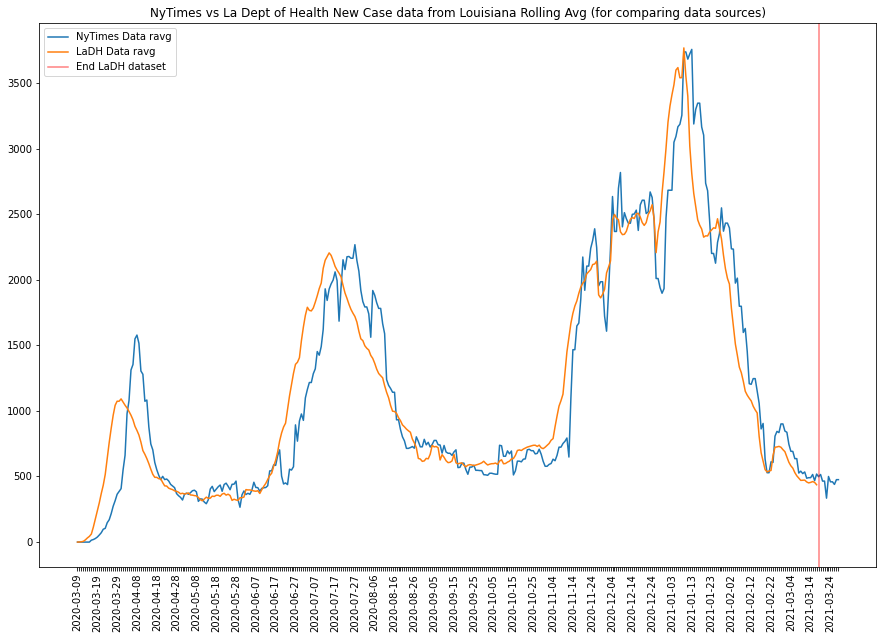

In [16]:
#Figure 9

fig,axs = plt.subplots(figsize=(15,10))

#axs.plot(la_df['date'],la_df['NewCases'], label='NyTimes Data')
#axs.plot(la2_df['date'],la2_df['NewCases'], label='LaDH Data')

axs.plot(la_df['date'],la_df['NewCasesRollAvg'], label='NyTimes Data ravg')
axs.plot(la2_df['date'],la2_df['NewCasesRollAvg'], label='LaDH Data ravg')

idx = 0
for label in axs.xaxis.get_ticklabels():
    
    if idx % 10 != 0:
        label.set_visible(False)
        
    idx = idx+1

axs.tick_params(axis='x', rotation=90)
axs.set_title("NyTimes vs La Dept of Health New Case data from Louisiana Rolling Avg (for comparing data sources)")

ladhdatamax(axs)
axs.legend()
fig.savefig("fig9.jpg")

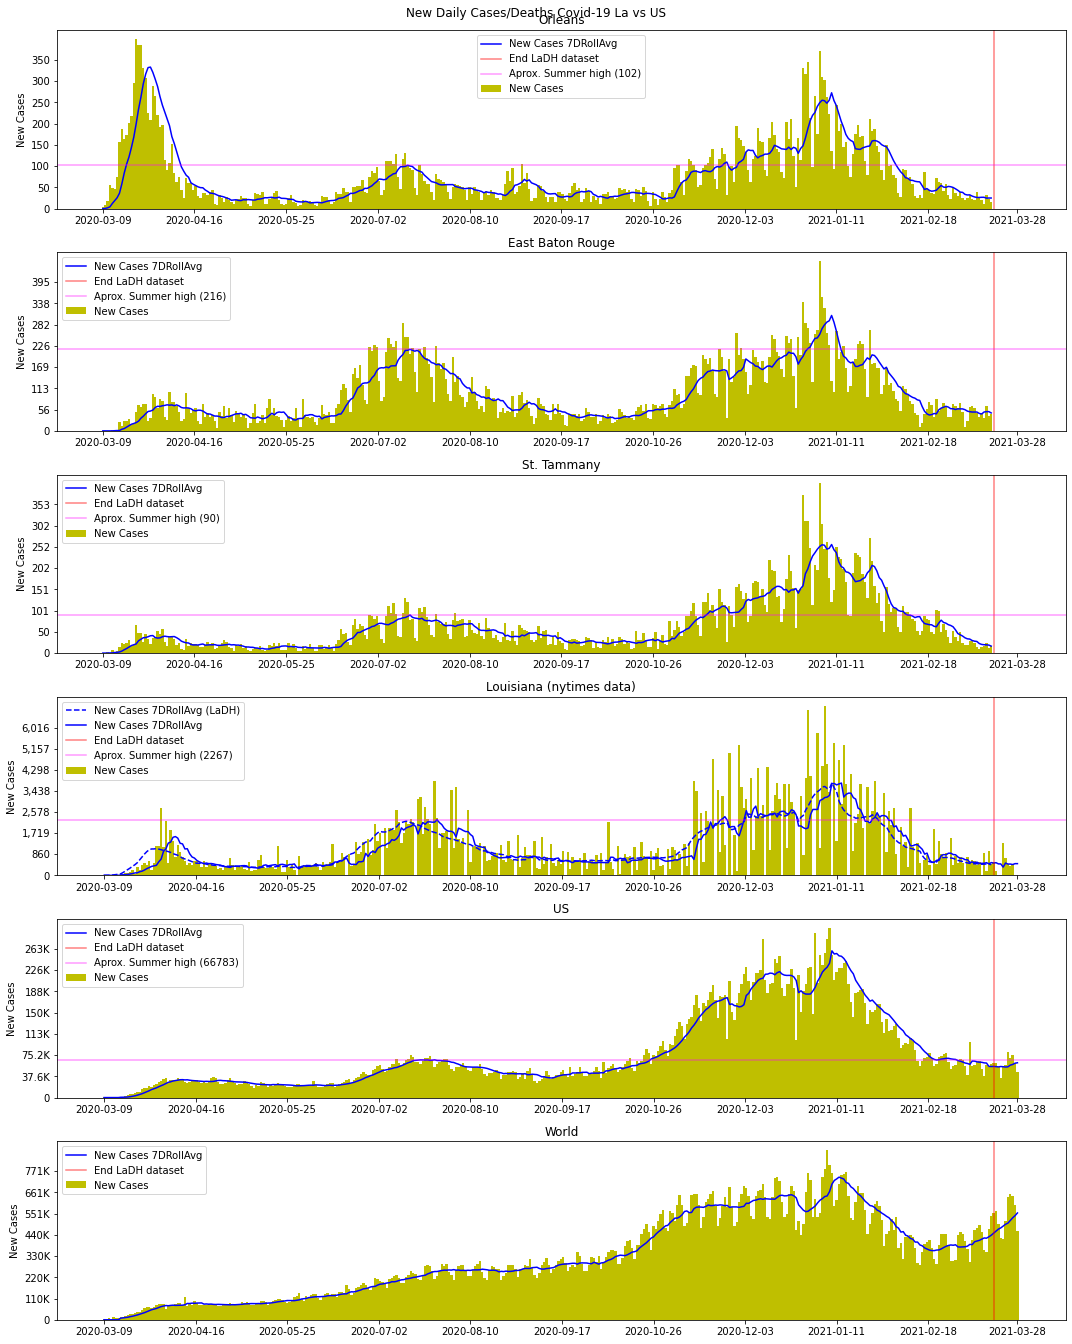

In [17]:
#Figure 1
fig, axs = plt.subplots(6, figsize=(15,19))

def plotme(df, ax,xticks,addeaths=True):
    


    ax.bar(df.index,df['NewCases'], color='y', label='New Cases', width=1.0)
    ax.plot(df.index,df['NewCasesRollAvg'], color = 'b',label='New Cases 7DRollAvg')
    
    if addeaths:
        ax.bar(df.index,df['NewDeaths'], color='r', label='New Deaths', width=1.0)
        ax.plot(df.index,df['NewDeathsRollAvg'], color = 'g', label='New Deaths 7DRollAvg')

    ax.set_xticks(us_ticks)
    ax.set_xticklabels(us_df.iloc[us_ticks,0])
    xmarg,_ = ax.margins()
    ax.set_xlim(xmax=xdatalen + (xdatalen * xmarg))
    
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ladhdatamax(ax)    
    yticks,yticklabels = getyTicks(df,'NewCases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Cases")
    
    #la data adjustment causes negative values on one day
    #this information is no longer relavent in the context of the larger data set
    ax.set_ylim(bottom=0) 
    
    
axs[0].title.set_text('Orleans')
plotme(orleans_df,axs[0],orleans_ticks, addeaths=False)

axs[1].title.set_text("East Baton Rouge")
plotme(ebr_df,axs[1],ebr_ticks,addeaths=False)

axs[2].title.set_text("St. Tammany")
plotme(tamm_df,axs[2],tamm_ticks,addeaths=False)

axs[3].title.set_text('Louisiana (nytimes data)')
#adjustments for LA data issue 4/19
#LACFline(la_df,axs[3])
axs[3].plot(la2_df.index,la2_df['NewCasesRollAvg'], linestyle='--',color = 'b',label='New Cases 7DRollAvg (LaDH)')
plotme(la_df,axs[3],la_ticks, addeaths=False)

axs[4].title.set_text('US')
plotme(us_df,axs[4],us_ticks, addeaths=False)

axs[5].title.set_text('World')
plotme(world_df,axs[5],world_ticks, addeaths=False)

#add lines for summer highs
summstart = pd.to_datetime('2020-05-01')
summend = pd.to_datetime('2020-09-01')
for curr_df, ax in [(orleans_df, axs[0]),(ebr_df,axs[1]),(tamm_df,axs[2]),(la_df,axs[3]),(us_df,axs[4])]:
    dts = pd.to_datetime(curr_df['date'])
    summermask = (dts > summstart) & ( dts < summend)
    summerhigh = curr_df['NewCasesRollAvg'][summermask].max()
    ax.axhline(summerhigh, label="Aprox. Summer high (%.0d)" % summerhigh, color='magenta', alpha=0.4)
 
for ax in fig.axes:
    ax.legend()
    
fig.suptitle("New Daily Cases/Deaths Covid-19 La vs US")
fig.tight_layout()
plt.savefig("fig1.jpg")


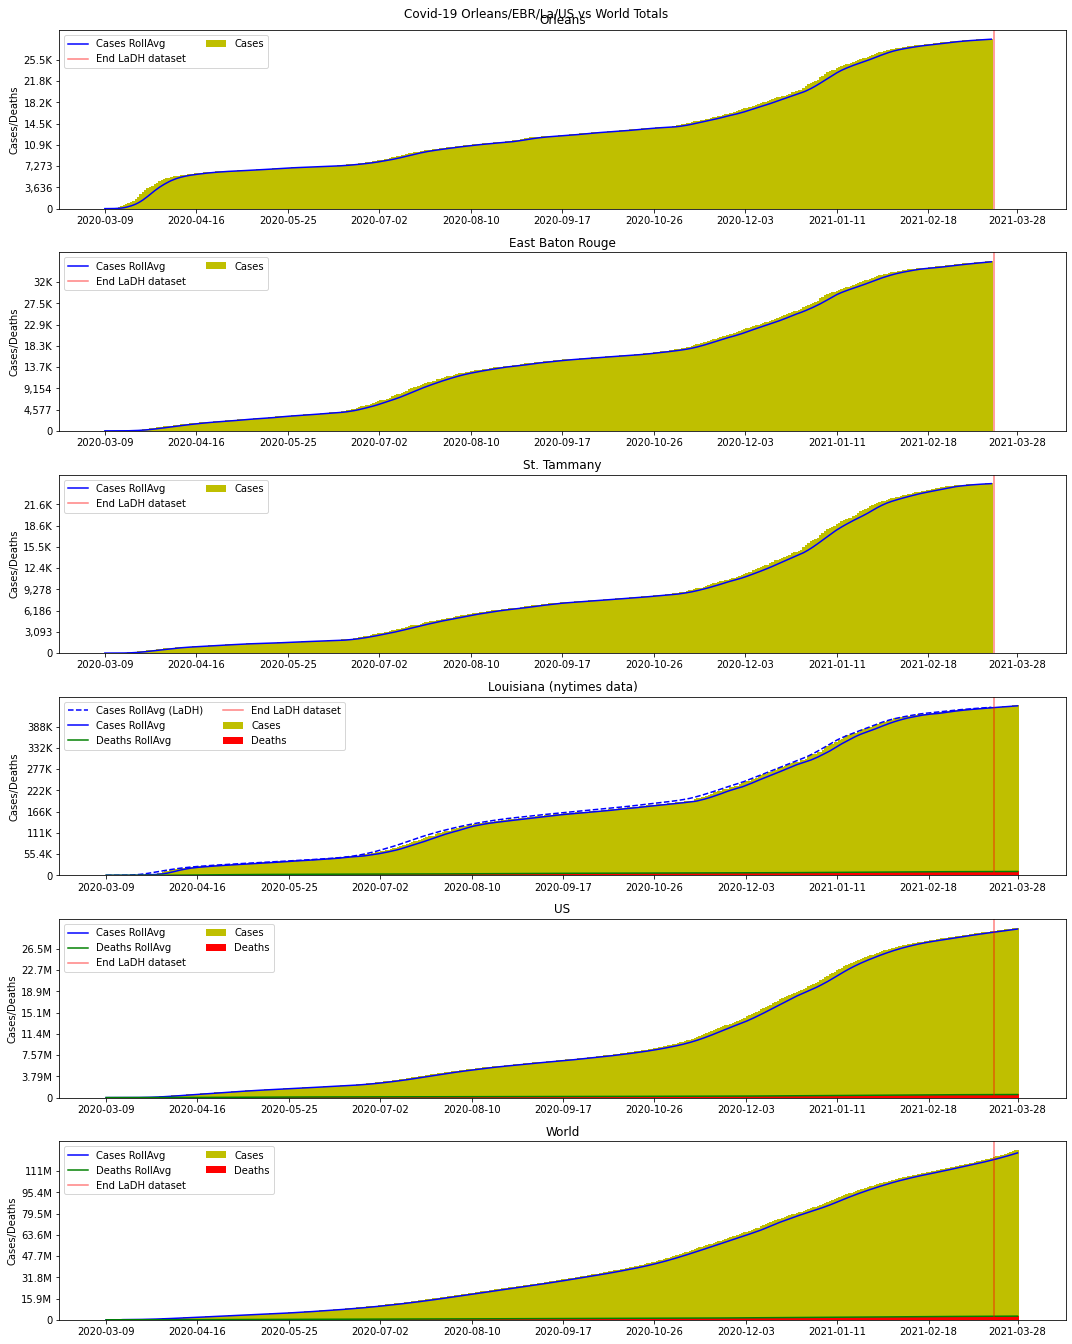

In [18]:
#Figure 2
fig, axs = plt.subplots(6, figsize=(15,19))

def plotme(df,ax, xticks, addeaths = True):
    ax.bar(df.index,df['cases'], color='y', label='Cases', width=1.0)
    ax.plot(df.index,df['cases_ravg'], color = 'b',label='Cases RollAvg')
    
    if addeaths:
        ax.bar(df.index,df['deaths'], color='r', label='Deaths', width=1.0)
        ax.plot(df.index,df['deaths_ravg'], color = 'g', label='Deaths RollAvg')
        
    ax.set_xticks(us_ticks)
    ax.set_xticklabels(us_df.iloc[us_ticks,0])
    xmarg,_ = ax.margins()
    ax.set_xlim(xmax=xdatalen + (xdatalen * xmarg))
    
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ladhdatamax(ax)
    ax.legend(ncol=2)
    

    yticks,yticklabels = getyTicks(df,'cases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("Cases/Deaths")

axs[0].title.set_text("Orleans")
plotme(orleans_df,axs[0],orleans_ticks, addeaths=False)

axs[1].title.set_text("East Baton Rouge")
plotme(ebr_df,axs[1],ebr_ticks, addeaths=False)

axs[2].title.set_text("St. Tammany")
plotme(tamm_df,axs[2],tamm_ticks,addeaths=False)

axs[3].title.set_text('Louisiana (nytimes data)')
axs[3].plot(la2_df.index,la2_df['cases_ravg'], linestyle='--', color = 'b',label='Cases RollAvg (LaDH)')
plotme(la_df,axs[3],la_ticks,addeaths=True)
#adjustments for LA data issue 4/19
#LACFline(la_df,axs[3])

axs[4].title.set_text('US')
plotme(us_df,axs[4],us_ticks)

axs[5].title.set_text("World")
plotme(world_df,axs[5],world_ticks)

fig.suptitle("Covid-19 Orleans/EBR/La/US vs World Totals")
fig.tight_layout()
plt.savefig("fig2.jpg")

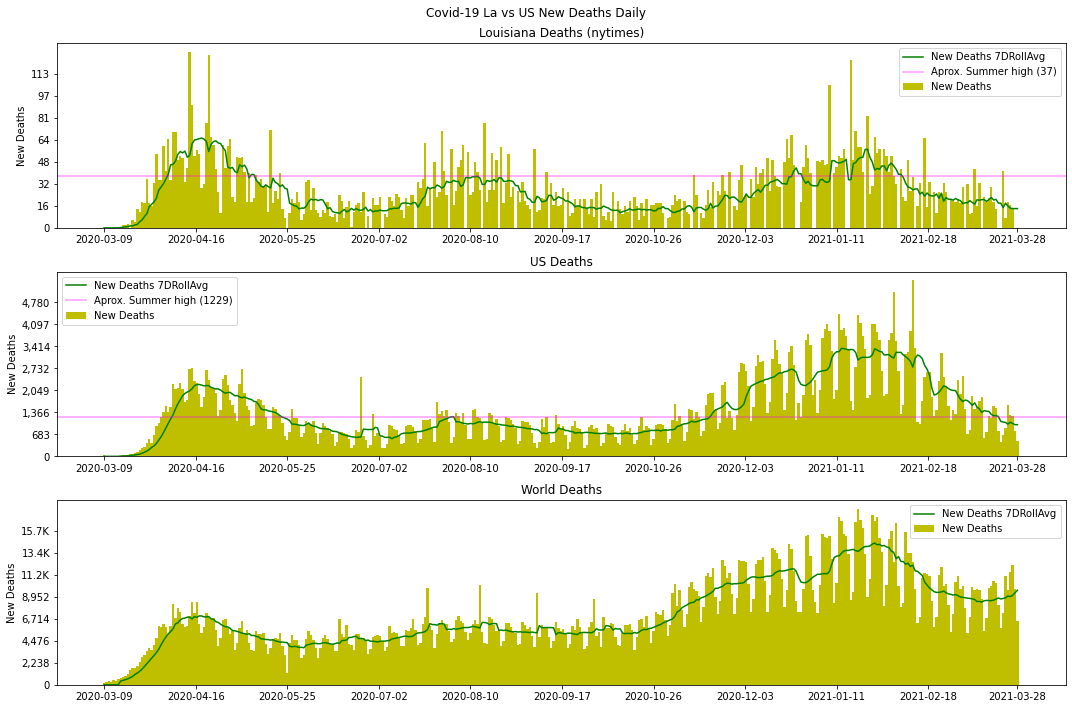

In [19]:
#Figure 3

fig, axs = plt.subplots(3, figsize=(15,10))

def plotme(df,ax,xticks):

    ax.bar(df.index,df['NewDeaths'], color = 'y', label="New Deaths", width=1.0)
    ax.plot(df.index,df['NewDeathsRollAvg'], color='g', label="New Deaths 7DRollAvg")
    
    ax.set_xticks(us_ticks)
    ax.set_xticklabels(us_df.iloc[us_ticks,0])
    xmarg,_ = ax.margins()
    ax.set_xlim(xmax=xdatalen + (xdatalen * xmarg))
    
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    #ladhdatamax(ax)  #no ladh data on this one
    ax.legend()

    yticks,yticklabels = getyTicks(df,'NewDeaths')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Deaths")

axs[0].title.set_text('Louisiana Deaths (nytimes)')

#adjustments for LA data issue 4/19
#LACFline(la_df,axs[0])

plotme(la_df,axs[0],la_ticks)


axs[1].title.set_text('US Deaths')
plotme(us_df,axs[1],us_ticks)

axs[2].title.set_text('World Deaths')
plotme(world_df,axs[2],world_ticks)

#add lines for summer highs
summstart = pd.to_datetime('2020-06-22')
summend = pd.to_datetime('2020-09-01')
for curr_df, ax in [(la_df,axs[0]),(us_df,axs[1])]:
    dts = pd.to_datetime(curr_df['date'])
    summermask = (dts > summstart) & ( dts < summend)
    summerhigh = curr_df['NewDeathsRollAvg'][summermask].max()
    ax.axhline(summerhigh, label="Aprox. Summer high (%.0d)" % summerhigh, color='magenta', alpha=0.4)
 
for ax in fig.axes:
    ax.legend()

fig.suptitle("Covid-19 La vs US New Deaths Daily")
fig.tight_layout()
plt.savefig("fig3.jpg")

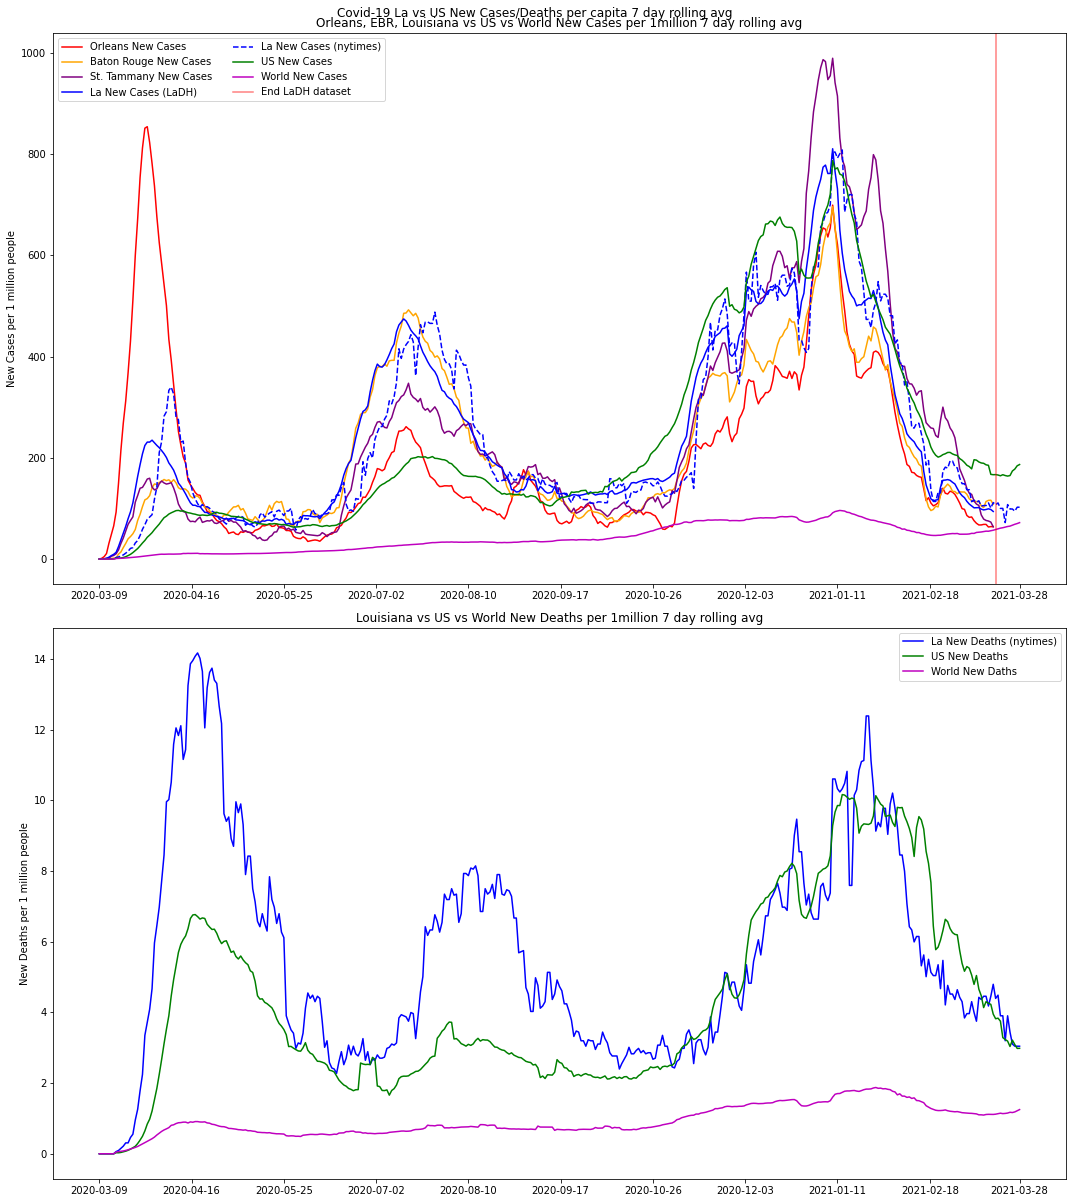

In [20]:
#Figure 4

#problem with the legend need to work on this
def plotme(df,ax,xticks, column, label, color = 'r', linestyle='-'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label, linestyle=linestyle))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax)) 
    
    return lines
    
    
fig, axs = plt.subplots(2, figsize=(15,17))

ax1lines = []
ax2lines = []

ax1lines.append( plotme(orleans_df,axs[0],orleans_ticks,'NewCasesPerCapita_ravg',"Orleans New Cases", color = 'r')[0][0])
ax1lines.append( plotme(ebr_df,axs[0],ebr_ticks,'NewCasesPerCapita_ravg',"Baton Rouge New Cases", color = 'orange')[0][0])
ax1lines.append( plotme(tamm_df,axs[0],orleans_ticks,'NewCasesPerCapita_ravg',"St. Tammany New Cases", color = 'purple')[0][0])
ax1lines.append( plotme(la2_df,axs[0],la2_ticks, 'NewCasesPerCapita_ravg',"La New Cases (LaDH)", color='b')[0][0])

ax1lines.append( plotme(la_df,axs[0],la_ticks, 'NewCasesPerCapita_ravg',"La New Cases (nytimes)", color='b', linestyle='--')[0][0])

ax1lines.append( plotme(us_df,axs[0],us_ticks, 'NewCasesPerCapita_ravg','US New Cases', color='g')[0][0])
ax1lines.append( plotme(world_df,axs[0],world_ticks,'NewCasesPerCapita_ravg',"World New Cases", color='m')[0][0])

ax1lines.append(ladhdatamax(axs[0]))

ax2lines.append( plotme(la_df,axs[1],la_ticks, 'NewDeathsPerCapita_ravg',"La New Deaths (nytimes)", color='b')[0][0])
ax2lines.append( plotme(us_df,axs[1],us_ticks, 'NewDeathsPerCapita_ravg','US New Deaths', color='g')[0][0])
ax2lines.append( plotme(world_df,axs[1],world_ticks,'NewDeathsPerCapita_ravg',"World New Daths", color='m')[0][0])

#ax2lines.append(ladhdatamax(axs[1]))  #no ladh data


#for col,ax in zip([('NewCasesPerCapita_ravg','New Cases'),('NewDeathsPerCapita_ravg', 'New Deaths')],((axs[0],ax1lines),(axs[1],ax2lines))):
    
#    ax[1].append( plotme(la_df,ax[0],la_ticks, col[0],"La %s" % col[1], color='b')[0][0])
#    ax[1].append( plotme(us_df,ax[0],us_ticks, col[0],'US %s' % col[1], color='g')[0][0])
#    ax[1].append( plotme(world_df,ax[0],world_ticks,col[0],"World %s" % col[1], color='m')[0][0])
    
axs[0].legend(handles=ax1lines,ncol=2)
axs[1].legend(handles=ax2lines)
    
    

axs[0].title.set_text('Orleans, EBR, Louisiana vs US vs World New Cases per 1million 7 day rolling avg')
axs[1].title.set_text('Louisiana vs US vs World New Deaths per 1million 7 day rolling avg')

axs[0].set_ylabel("New Cases per 1 million people")
axs[1].set_ylabel("New Deaths per 1 million people")

fig.suptitle("Covid-19 La vs US New Cases/Deaths per capita 7 day rolling avg ")
fig.tight_layout()
plt.savefig("fig4.jpg")

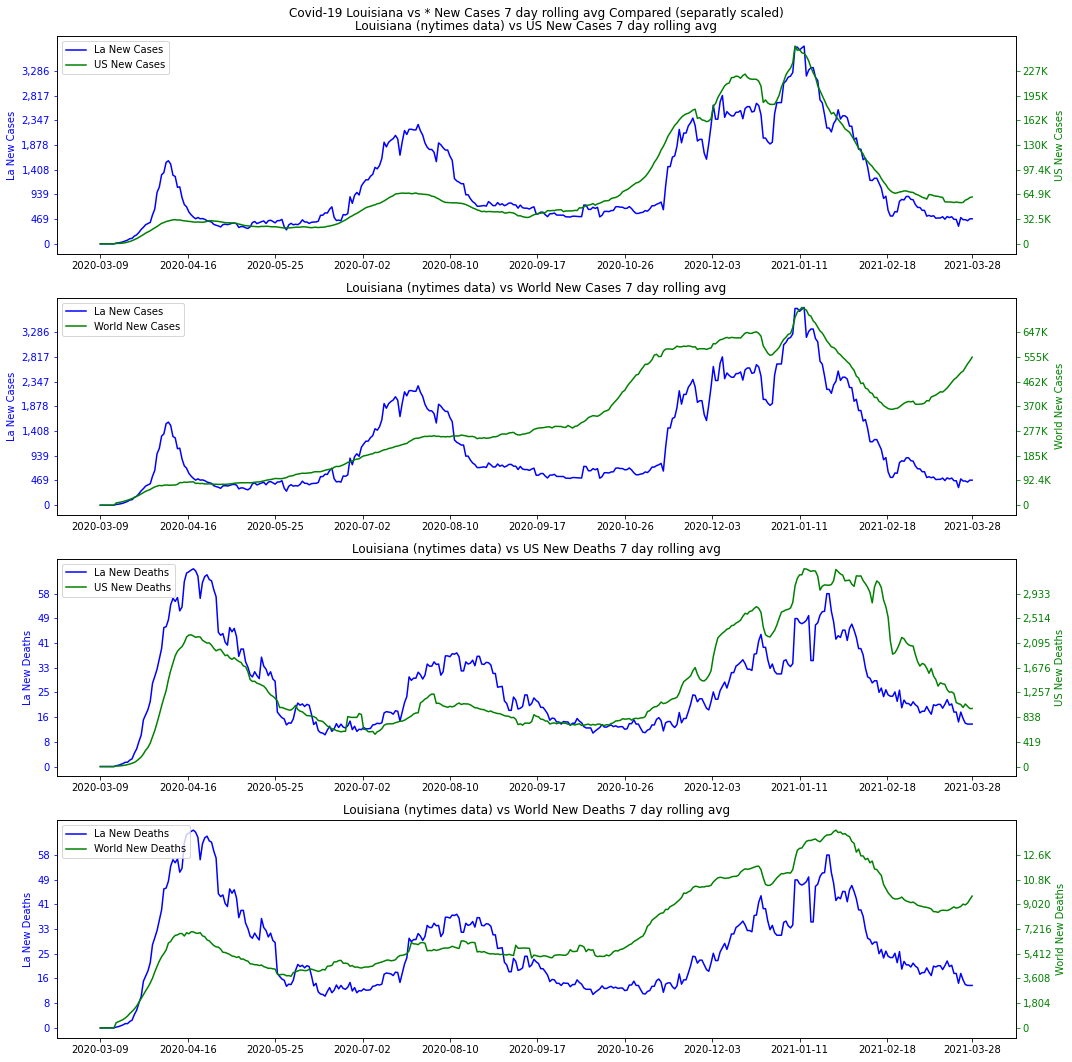

In [21]:
#Figure 5

#problem with the legend need to work on this
def plotme(df,ax,xticks, column, label, color = 'r'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax))
    #lines.append(LACFline(df,ax))   #I'm not sure the data for deaths and cases was effected by the adjustment
    
    yticks,yticklabels = getyTicks(df,column)
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel(label,color=color)
    ax.tick_params(axis='y',color=color,labelcolor=color)
    
    return lines
    
    
fig, axs = plt.subplots(4, figsize=(15,15))

idx = 0
for col, label in zip(['NewCasesRollAvg','NewDeathsRollAvg'], ['New Cases','New Deaths']):
    for compare_place, label_place in zip([(us_df,us_ticks),(world_df,world_ticks)], ['US','World']):
        line1 = plotme(la_df,axs[idx],la_ticks, col,"La %s" % label, color='b')
        axsY2 = axs[idx].twinx()
        line2 = plotme(compare_place[0],axsY2,compare_place[1], col,"%s %s" % (label_place, label), color='g')
        axs[idx].legend(handles=[line1[0][0],line2[0][0]],loc='upper left')
        axs[idx].title.set_text("Louisiana (nytimes data) vs %s %s 7 day rolling avg"%(label_place,label))
        idx += 1
    
fig.suptitle("Covid-19 Louisiana vs * New Cases 7 day rolling avg Compared (separatly scaled)")
fig.tight_layout()
plt.savefig("fig5.jpg")

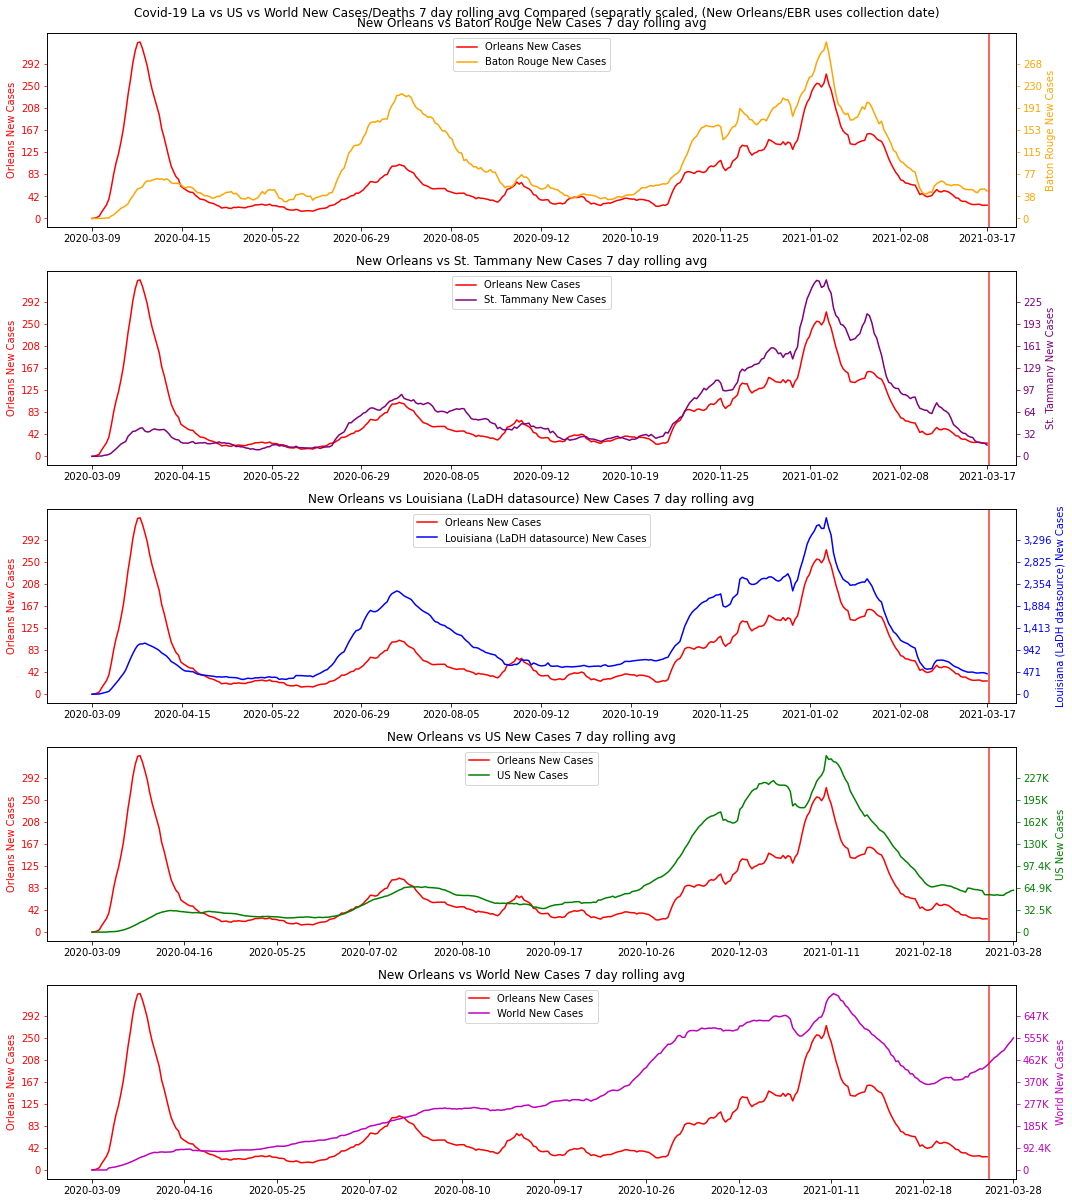

In [22]:
#Figure 5

#problem with the legend need to work on this
def plotme(df,ax,xticks, column, label, color = 'r'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax))
    #lines.append(LACFline(df,ax))   #I'm not sure the data for deaths and cases was effected by the adjustment
    lines.append(ladhdatamax(ax))
    
    yticks,yticklabels = getyTicks(df,column)
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel(label,color=color)
    ax.tick_params(axis='y',color=color,labelcolor=color)
    ax.set_xlim(xmax=xdatalen)
    
    return lines
    
    
fig, axs = plt.subplots(5, figsize=(15,17))

idx = 0
col = 'NewCasesRollAvg'
label = 'New Cases'
for compare_place, label_place in zip([(ebr_df,ebr_ticks,'orange'),(tamm_df,tamm_ticks,'purple'), (la2_df,la2_ticks,'b'), (us_df,us_ticks,'g'),(world_df,world_ticks,'m')], ['Baton Rouge', 'St. Tammany','Louisiana (LaDH datasource)','US','World']):
    line1 = plotme(orleans_df,axs[idx],orleans_ticks, col,"Orleans %s" % label, color='r')
    axsY2 = axs[idx].twinx()
    line2 = plotme(compare_place[0],axsY2,compare_place[1], col,"%s %s" % (label_place, label), color=compare_place[2])
    axs[idx].legend(handles=[line1[0][0],line2[0][0]])
    axs[idx].title.set_text("New Orleans vs %s %s 7 day rolling avg"%(label_place,label))
    idx += 1

fig.suptitle("Covid-19 La vs US vs World New Cases/Deaths 7 day rolling avg Compared (separatly scaled, (New Orleans/EBR uses collection date)")
fig.tight_layout()
plt.savefig("fig8.jpg")

In [23]:
weeks = []
day = mindate
deltaweek = timedelta(days=7)
enddate = datetime.now() - deltaweek
while day <= enddate:
    weeks.append(day)
    day = day + deltaweek

      
def getWeeklyDF(df):
    
    df.index = df['date'].map( lambda x: pd.Timestamp(x))
    dfmaxdate = pd.to_datetime(df.index.max())
    enddate = dfmaxdate - timedelta(days=7)
    
    newdf = pd.DataFrame(index = weeks)
    
    columns = ['NewCases', 'NewDeaths']
    for column in columns:
        if column in df.columns:
        
            totals = []
            deltaweek = timedelta(days=7)
            for week in weeks:
                if week <= enddate:
                    mask = (df.index < week + deltaweek) & (df.index >= week)
                    totals.append(np.nansum(df[column][mask]))
                else:
                    totals.append(np.nan)
                
            newdf[column] = pd.Series(totals,index=weeks)
            newcol = column + 'RollAvg'
            newdf[newcol] = rollingavg(newdf[column],3)
            newdf[newcol] = np.where(newdf[column] > 0, newdf[newcol], np.nan)

    return newdf

orleans_df_weekly = getWeeklyDF(orleans_df) #pd.DataFrame(orleans_df.groupby('week')['NewCases'].sum())
ebr_df_weekly = getWeeklyDF(ebr_df) #pd.DataFrame(ebr_df.groupby('week')['NewCases'].sum())
tamm_df_weekly = getWeeklyDF(tamm_df)#pd.DataFrame(tamm_df.groupby('week')['NewCases'].sum())
la2_df_weekly = getWeeklyDF(la2_df)#pd.DataFrame(la2_df.groupby('week')['NewCases'].sum())
la_df_weekly = getWeeklyDF(la_df)#la_df.groupby('week')[['NewCases','NewDeaths']].sum()
us_df_weekly = getWeeklyDF(us_df)#.groupby('week')[['NewCases','NewDeaths']].sum()
world_df_weekly = getWeeklyDF(world_df)#.groupby('week')[['NewCases','NewDeaths']].sum()

print(weeks[-1])
world_df_weekly.tail()
#us_df_weekly.tail(2)

2021-03-21 00:00:00


,NewCases,NewCasesRollAvg,NewDeaths,NewDeathsRollAvg
2021-02-21,2715951.0,2.838052e+06,64444.0,78377.000000
2021-02-28,2671731.0,2.682229e+06,61731.0,70558.000000
2021-03-07,2969323.0,2.632511e+06,59876.0,64171.000000
2021-03-14,3335010.0,2.785668e+06,61199.0,62017.000000
2021-03-21,3876780.0,2.992021e+06,67347.0,60935.333333


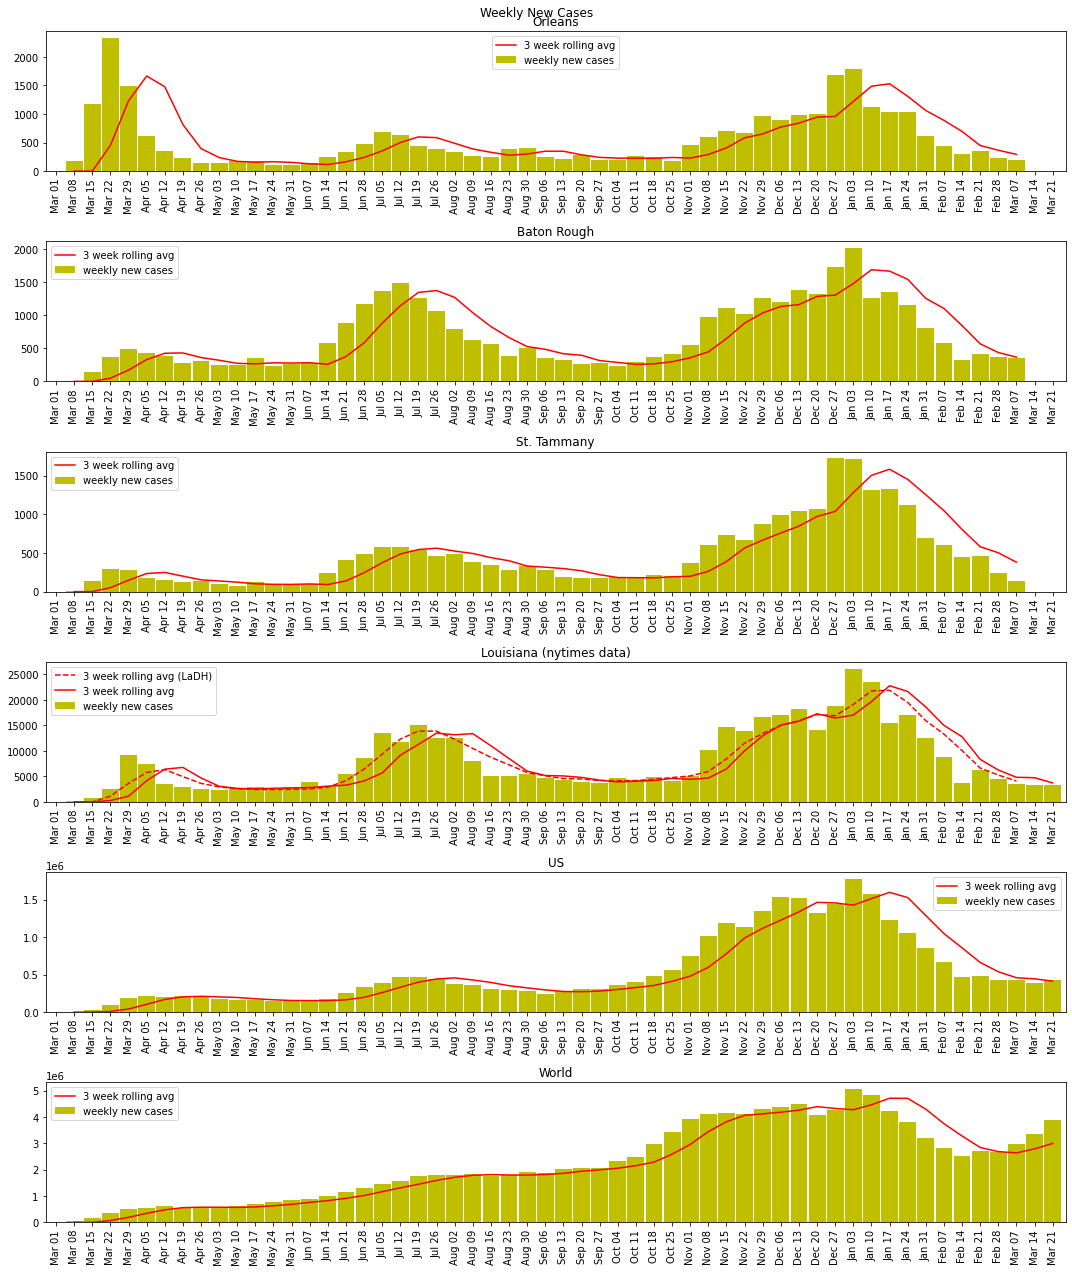

In [24]:
#Figure 6

def plotme(df,ax, title = "Graphs", color = 'y', linecolor = 'r'):
    ax.bar(df.index,df['NewCases'], color=color, label='weekly new cases', width=6.5)
    ax.plot(df.index,df['NewCasesRollAvg'], color=linecolor, label='3 week rolling avg')
    
    ax.set_title(title)
    ax.set_xticks(df.index)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.tick_params(axis='x',rotation=90)
    ax.set_xlim((weeks[0]-timedelta(days=4),weeks[-1] + timedelta(days=5)))
    ax.legend()
      
fig, axs = plt.subplots(6, figsize=(15,18))
fig.suptitle("Weekly New Cases")

plotme(orleans_df_weekly,axs[0], title="Orleans")
plotme(ebr_df_weekly,axs[1],title="Baton Rough")
plotme(tamm_df_weekly,axs[2],title="St. Tammany")


axs[3].plot(la2_df_weekly.index, la2_df_weekly['NewCasesRollAvg'], linestyle='--', color='r', label='3 week rolling avg (LaDH)')
plotme(la_df_weekly,axs[3], title="Louisiana (nytimes data)")
plotme(us_df_weekly,axs[4], title="US")
plotme(world_df_weekly,axs[5],title="World")

fig.tight_layout()

plt.savefig("fig6.jpg")

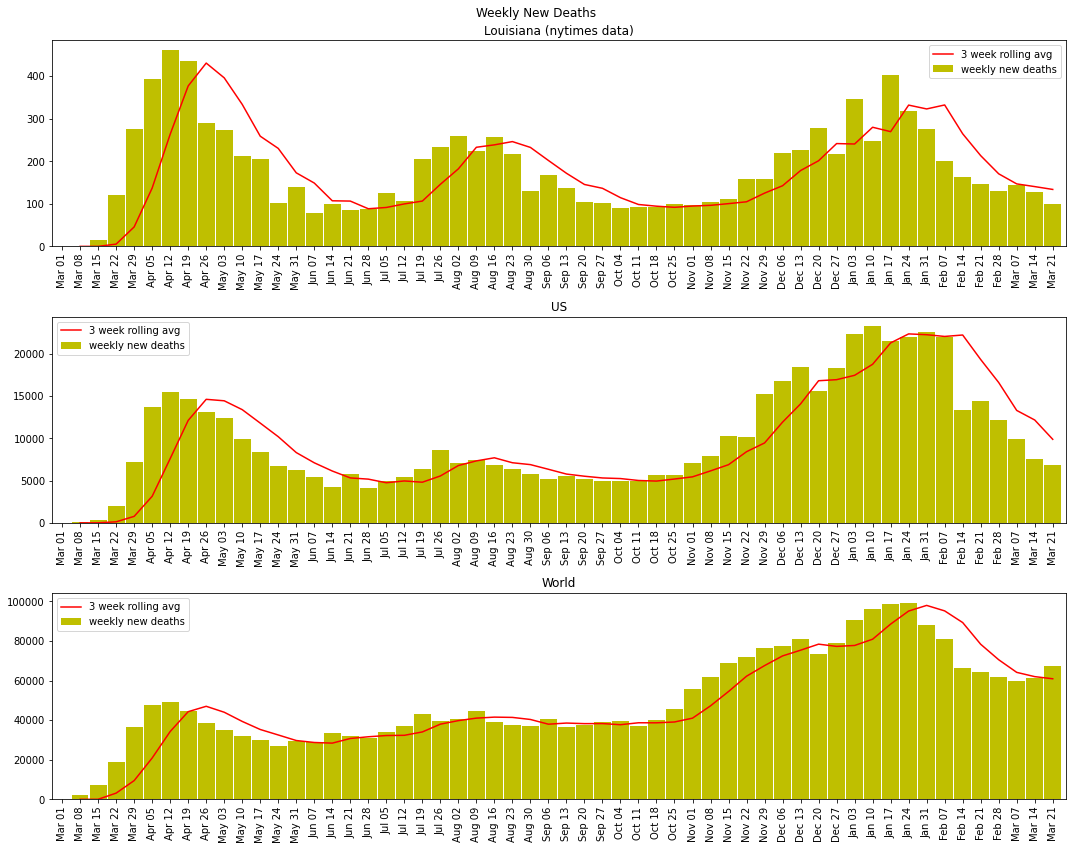

In [25]:
#Figure 7

def plotme(df,ax, title = "Graphs", color = 'y', linecolor='r'):
    ax.bar(df.index,df['NewDeaths'], color=color, label='weekly new deaths', width=6.5)
    ax.plot(df.index,df['NewDeathsRollAvg'], color=linecolor, label='3 week rolling avg')
    
    ax.set_title(title)
    ax.set_xticks(df.index)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.tick_params(axis='x',rotation=90)
    ax.set_xlim((weeks[0]-timedelta(days=4),weeks[-1] + timedelta(days=5)))
    ax.legend()
    
fig, axs = plt.subplots(3, figsize=(15,12))
fig.suptitle("Weekly New Deaths")

plotme(la_df_weekly,axs[0], title="Louisiana (nytimes data)")
plotme(us_df_weekly,axs[1], title="US")
plotme(world_df_weekly,axs[2],title="World")

fig.tight_layout()

plt.savefig("fig7.jpg")